## Workflow to process and geotag RAW image files 
This workflow aims to be a single point of reference for what appears to be a challenging and cryptic process, laden with labourious command line programs or third party software. This workflow is specific in its use, and requires data input from post processed kinematic (PPK) GNSS receivers, namely produced by EMLID, and open source, light-weight alternative to the more commonly employed big names like Trimble. 

The general workflow here is to take PPK event logs, associate them with image names, and assign exif GPS location data to the images. If the images are collected in RAW format, a RAW - 8 or 16 bit tiff conversion can be inserted into the workflow. See the code and examples below for clarity.

### Required libraries

In [521]:
import rawpy
import rawpy.enhance
import io
from PIL import Image
import piexif
from math import *
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

dataDir = 'Y:/DanK/SfM/Teakettle_2017/Photos/BC1_1/'
outputDir = dataDir + 'tifOutput/'

### Function definition
The overall process here is to manage reading in and converting imagery to a useable format, reading in PPK event logs and generating apropriate exif data for establishing geotags, then inserting the updated exif data into a new copy of the image.

In [610]:
# return position file location (*.pos) from inside image directory
#decimal degrees to degrees, minutes, seconds
def gen_DDMMSS(degrees):
    minutes = degrees%1.0*60
    seconds = degrees%1.0*60    
    return ((abs(int(floor(degrees))), 1), 
            (int(floor(minutes*100)), 100), 
            (int(floor(seconds*100000)), 100000))

def gen_GPSDATE(date, gpst):
    date = date.replace('/', ':')
    GPS_TS = date + ' ' + gpst
    return unicode(GPS_TS)

def gen_HEIGHT(height):
    modheight = (int(floor(height * 10000)), 10000)
    return modheight

def getSortedImages(imageDir, filetype):
    imglist = next(os.walk(imageDir))[2]
    filtImgs = filter(lambda s: filetype in str(s), imglist)
    return sorted(filtImgs)

def gen_GPSexif(height, gpst, lat, lon):   
        gps_if = { piexif.GPSIFD.GPSVersionID: (2, 3, 0, 0),
           piexif.GPSIFD.GPSLatitude: lat,
           piexif.GPSIFD.GPSLatitudeRef: 'N',
           piexif.GPSIFD.GPSLongitude: lon,
           piexif.GPSIFD.GPSLongitudeRef: 'W',
           piexif.GPSIFD.GPSAltitude: height,
           piexif.GPSIFD.GPSAltitudeRef: 0,
           piexif.GPSIFD.GPSDateStamp: gpst
          }
        return gps_if

def get_pos_file(inputDir):
    # Find the .pos file in the processed tif directory
    for filename in os.listdir(inputDir):
        if filename.endswith(".pos"):
            ppkPos = filename
            
            # Read in the pos file and correct the column headers
            # and return it
            df = pd.read_csv(inputDir + ppkPos, header = 24, sep=r"\s*")
            posDF = df.rename(columns={'%': 'Date'})
            return posDF
        
def plotEvents(PPK_Events):
    f, (ax) = plt.subplots(1,1, figsize =(7,7))
    sns.set_style('ticks')
    sns.set_context('notebook', font_scale=1.5)
    sns.despine(left=True, bottom=True)
    C = ['green','gray','orange']
    labs = ['Integer','Float','Single']
    y = PPK_Events['latitude(deg)']
    x = PPK_Events['longitude(deg)']
    ax.plot(x, y, '--', color = 'gray', alpha = 0.5)

    idx = 0
    for thisQ in np.unique(PPK_Events.Q):
        ppksub = PPK_Events[PPK_Events.Q == thisQ]
        y = ppksub['latitude(deg)']
        x = ppksub['longitude(deg)']
        ax.scatter(x, y, color = C[idx], s = 45, label=labs[idx])
        idx += 1
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.legend(loc = 2)
    
def convertImages(imageDir, outputDir): 
    imgList      =  getSortedImages(dataDir, '.ARW')
    fullImgNames = [next(os.walk(dataDir))[0] + s for s in imageDir]

    if not os.path.exists(outputDir):
        os.makedirs(outputDir)
    if not os.path.exists(outputDir + 'geoJPEG/'):
        os.makedirs(outputDir + 'geoJPEG/')
        
    print 'converting RAW images to tif ...'
    for img in imgList:
        # print 'post-processing ' + img + ' to tif...'
        ARWimgage = rawpy.imread(dataDir + img)
        TIFimage = ARWimgage.postprocess(output_bps = 8)
        imageio.imwrite(outputDir + img + '.tiff', TIFimage)

def geoTagImages(PPK_Events, imageLocation):    
    #Note here that we also generate a list of the processed images    
    procList      =  next(os.walk(imageLocation))[2]
    
    print 'Gathering PPK event data ...'
    imglist = getSortedImages(imageLocation, 'tif')
    PPK_Events['images'] = imglist

    for row in PPK_Events.index:
        exif_dict = piexif.load(outputDir + procList[row])

        height = gen_HEIGHT(PPK_Events['height(m)'][row])
        gpst   = gen_GPSDATE(PPK_Events.Date[0], ppk_events.GPST[row])
        lat    = gen_DDMMSS(PPK_Events['latitude(deg)'][row])
        lon    = gen_DDMMSS(PPK_Events['longitude(deg)'][row])

        gps_ifd = gen_GPSexif(height, gpst, lat, lon)

        exif_dict['GPS'] = gps_ifd

        exifbytes = piexif.dump(exif_dict)

        im = Image.open(outputDir + PPK_Events.images[row])
        im.save(outputDir + 'geoJPEG/' + PPK_Events.images[row], "jpeg", exif=exifbytes)
        im.close()


### This makes the workflow fairly straight forward
#### First the PPK file generated using an EMLID Reach radio is read in as a pandas dataframe, 
and the sorted image list associated with the specific collection is appended to that dataframe. This lets us 1) check that the number of photos matches the number of 'events' tags in the collection. Currently, using a Sony a6000 and a hotshoe trigger on the Reach, every time the shutter activates, a log file should be entered into the events file. However, after a ton of misery, I figured out that if the fix status of the GNSS receiver at the time of the image acquisition was 'single', meaning not able to be corrected in the context of a base station, the trigger event is removed from the events list -- the problem being, we don't know which photo that corresponds with, and because we rely on the order of images matching up with the order of evens triggerd by the Reach, that puts us SOL.

In [580]:
imgList      =  next(os.walk(dataDir))[2]
fullImgNames = [next(os.walk(dataDir))[0] + s for s in imageDir]

# Here's what the events file looks like with the appended photo names
ppk_events = get_pos_file(dataDir)
imglist = getSortedImages(outputDir)
ppk_events['images'] = imglist
ppk_events.head()

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:32: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


,Date,GPST,latitude(deg),longitude(deg),height(m),Q,ns,sdn(m),sde(m),sdu(m),sdne(m),sdeu(m),sdun(m),age(s),ratio,images
0,2017/06/20,17:35:34.655,36.958004,-119.022528,2006.2499,1,12,0.0060,0.0061,0.0153,-0.0017,0.0043,-0.0051,-0.0,16.3,DSC00068.ARW.tiff
1,2017/06/20,17:38:25.056,36.957581,-119.023345,2106.0327,1,14,0.0059,0.0056,0.0134,-0.0015,0.0043,-0.0036,-0.0,9.8,DSC00069.ARW.tiff
2,2017/06/20,17:38:29.294,36.957752,-119.023369,2106.0288,1,13,0.0061,0.0061,0.0145,-0.0020,0.0057,-0.0041,-0.0,247.1,DSC00070.ARW.tiff
3,2017/06/20,17:38:33.098,36.957921,-119.023393,2105.9740,1,12,0.0063,0.0060,0.0148,-0.0025,0.0055,-0.0053,-0.0,179.9,DSC00071.ARW.tiff
4,2017/06/20,17:38:36.634,36.958080,-119.023410,2105.9893,1,13,0.0060,0.0060,0.0144,-0.0023,0.0054,-0.0046,-0.0,34.6,DSC00072.ARW.tiff


### To visualize what this looks like
We can plot the track of the UAS over the course of the events log (note, we're not actually tracking the entire flight of the UAS... just connecting the dots between when it supposedly acquired an image). We can go a step further and colorize the images according to the level of certainty that we have about its location. Green indicates an integer fix, gray a float fix, and orange a single.

I'll work on getting a scale bar in the scene instead of the axes in the future.

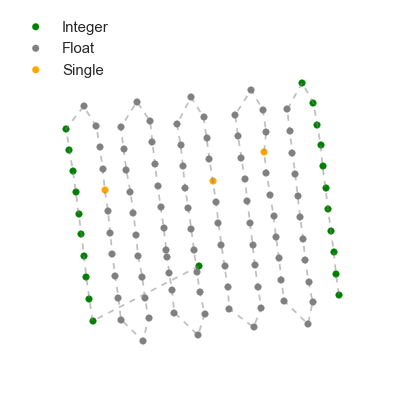

In [568]:
plotEvents(ppk_events)

### Now that we have the GNSS post-processed data
in a format that we can use and combine with specific images, we are ready to move on to inserting the geotagged data into the images themselves. Really though, we need to do some converting from RAW first, and then we're going to add the exif data into a copy of the converted image.

### Read in the RAW image
and convert it to a tif with a specific set of parameters to control brightness, and bit depth. Currently it was far simpler to append exif data with specific geotags to a JPEG compressed version of the image. That being said, we ultimately want to be operating on the 16 bit version of teh geoTIFF output from the RAW version of the image. For the time being, the current workflow is to read in the RAW image, export an 8 bit tif, and create a JPEG compressed copy that contains the geolocation exif data.


In [445]:
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
    
if not os.path.exists(outputDir + 'geoJPEG/'):
    os.makedirs(outputDir + 'geoJPEG/')

for img in imgList:
    # print 'post-processing ' + img + ' to tif...'
    ARWimgage = rawpy.imread(dataDir + img)
    TIFimage = ARWimgage.postprocess(output_bps = 8)
    imageio.imwrite(outputDir + img + '.tiff', TIFimage)
    
# Note here that we also generate a list of the processed images    
procList      =  next(os.walk(outputDir))[2]
fullProcNames = [next(os.walk(outputDir))[0] + s for s in procList]

### Now we can generate some variables to insert into the exif data
for the processed imagery. I start here by creating the variables we need to include in the exif data to 'geotag' the images. Then we load the exif data from an image into a dictionary, and insert another dictionary with a specific name 'GPS' into it. This GPS dict has a very specific format for how information needs to be described, and the ontology here is rather unforgiving. Here is an example for a single image.

In [574]:
height = gen_HEIGHT(test['height(m)'][0])
gpst   = gen_GPSDATE(test.Date[0], test.GPST[0])
lat    = gen_DDMMSS(test['latitude(deg)'][0])
lon    = gen_DDMMSS(test['longitude(deg)'][0])
print 'Height: ' + str(height)
print 'GPS time: ' + str(gpst)
print 'Latitude:' + str(lat)
print 'Longitude:' + str(lon)

height: (20116612, 10000)
GPS time: 2017:06:20 17:35:34.655
Latitude:((36, 1), (5748, 100), (5748082, 100000))
Longitude:((120, 1), (5864, 100), (5864859, 100000))


#### Notice here that while this particular image was collected in CA,
the longitude degrees field is positive. There is a separate GPSLongitudeRef field that we must specify in the exif dictionary to indicate 'W' or 'E'. The whole dictionary is full of requirements like this, and summary descriptions of the exif header data are cryptic at best. The libary piexif was the best tool I could find to make this a less painful process, and even still the documentation is lacking, and rife with errors. 

#### Now we can create a template for the exif data

In [576]:
exif_dict = piexif.load(outputDir + procList[1])
exif_dict

{'0th': {254: 0,
  256: 6024,
  257: 4024,
  258: (8, 8, 8),
  259: 1,
  262: 2,
  270: '{"shape": [4024, 6024, 3]}',
  273: 291,
  277: 3,
  278: 4024,
  279: 72721728,
  284: 1,
  305: 'tifffile.py',
  306: '2017:12:12 10:22:51',
  339: 1},
 '1st': {},
 'Exif': {},
 'GPS': {},
 'Interop': {},
 'thumbnail': None}

### Note the empty 'GPS' entry in the parent dictionary.
This is the field that we must inser the following data into. The rest of the exif modification workflow is pretty straight forward, so long as the cryptic format for each individual field is followed precisely.

In [579]:
# Create the GPS dictionary
gps_if = { piexif.GPSIFD.GPSVersionID: (2, 3, 0, 0),
           piexif.GPSIFD.GPSLatitude: lat,
           piexif.GPSIFD.GPSLatitudeRef: 'N',
           piexif.GPSIFD.GPSLongitude: lon,
           piexif.GPSIFD.GPSLongitudeRef: 'W',
           piexif.GPSIFD.GPSAltitude: height,
           piexif.GPSIFD.GPSAltitudeRef: 0,
           piexif.GPSIFD.GPSDateStamp: gpst
          }

# Add the dictionary to the larger exif dict that we loaded from the image
exif_dict['GPS'] = gps_if

# Convert the exif dict to bytes
exifbytes = piexif.dump(exif_dict)

# Use PIL to open a copy of the image, and save a copy with explicit new exif data
im = Image.open(outputDir + procList[0])
im.save(outputDir + 'geoJPEG/' + procList[0], "jpeg", exif=exifbytes)
im.close()

### Those being the separate steps for each individual image,
We can apply them to entire batches of images, for instance for a given flight. This reduces the workflow to a couple tasks, 1) get the PPK data, 2) convert the imagery (if it is indeed in RAW format), and 3) write the geotags to the exif data. Pretty slick, but data structures are important. See the README for example file formats and directory structures.

#### Here is the resulting code to complete the conversion and geotagging

In [616]:
dataDir    = 'Y:/DanK/SfM/Teakettle_2017/Photos/BC1_1/'
outputDir  = 'Y:/DanK/SfM/Teakettle_2017/Photos/BC1_1/tifOutput/'
ppk_events = get_pos_file(dataDir)

convertImages(dataDir, outputDir)
geoTagImages(ppk_events, outputDir)

Gathering PPK event data ...
